# NuClick:Interactive Annotation for Pathology

### Inference Notebook
It makes use of pretrained weights for the model from MONAI Bundle for NuClick.  However if you have trained model, you can use the same instead.

In [1]:
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from monai.apps.nuclick.transforms import AddClickSignalsd, PostFilterLabeld
from monai.apps.utils import download_and_extract
from monai.bundle import download
from monai.data import PILReader
from monai.networks.nets import BasicUNet
from monai.transforms import (
    Activationsd,
    AsDiscreted,
    EnsureChannelFirstd,
    LoadImage,
    LoadImaged,
    ScaleIntensityRangeD,
    SqueezeDimd,
)
from monai.utils import convert_to_numpy

In [3]:
workspace_path = os.path.normpath("workspace/")
max_epochs = 1

## Define Model Path for Inference

Download Bundle for NuClick model or Define your own path for pre-trained model for NuClick.

In [4]:
bundle_name = "pathology_nuclick_annotation"
bundle_version = "0.0.1"

bundle_path = os.path.join(workspace_path, bundle_name)
if not os.path.exists(bundle_path):
    download(name=bundle_name, version=bundle_version, bundle_dir=workspace_path)

model_weights_path = os.path.join(bundle_path, "models", "model.pt")

2022-12-06 10:37:36,251 - INFO - --- input summary of monai.bundle.scripts.download ---
2022-12-06 10:37:36,253 - INFO - > name: 'pathology_nuclick_annotation'
2022-12-06 10:37:36,253 - INFO - > version: '0.0.1'
2022-12-06 10:37:36,254 - INFO - > bundle_dir: 'workspace'
2022-12-06 10:37:36,255 - INFO - > source: 'github'
2022-12-06 10:37:36,255 - INFO - > repo: 'Project-MONAI/model-zoo/hosting_storage_v1'
2022-12-06 10:37:36,255 - INFO - > progress: True
2022-12-06 10:37:36,257 - INFO - ---




pathology_nuclick_annotation_v0.0.1.zip: 55.6MB [00:03, 18.9MB/s]                                                                                                                                                                                              

2022-12-06 10:37:39,346 - INFO - Downloaded: workspace/pathology_nuclick_annotation_v0.0.1.zip
2022-12-06 10:37:39,347 - INFO - Expected md5 is None, skip md5 check for file workspace/pathology_nuclick_annotation_v0.0.1.zip.
2022-12-06 10:37:39,349 - INFO - Writing into directory: workspace.


In [5]:
device = torch.device("cuda")
network = BasicUNet(spatial_dims=2, in_channels=5, out_channels=1, features=(32, 64, 128, 256, 512, 32))

checkpoint = torch.load(model_weights_path, map_location=torch.device(device))
model_state_dict = checkpoint.get("model", checkpoint)
network.load_state_dict(model_state_dict, strict=True)

BasicUNet features: (32, 64, 128, 256, 512, 32).


Can't initialize NVML


<All keys matched successfully>

## Per transform visualization for how the data gets prepared for inference

In [6]:
def show_image(image, label=None, sig=None, guidance=None, size=(12, 6)):
    if image.shape[0] == 3:
        image = np.moveaxis(image, 0, 2)
    if label is not None and label.shape[0] == 3:
        label = np.moveaxis(label, 0, 2)

    plt.figure("check", size)
    m = 1
    n = 1
    if sig is not None:
        n = 3
    elif label is not None:
        n = 2
    plt.subplot(m, n, 1)

    plt.title("image")
    plt.imshow(image, cmap="gray")

    if label is not None:
        masked = np.ma.masked_where(label == 0, label)
        plt.imshow(masked, "jet", interpolation="none", alpha=0.5)

    if guidance is not None:
        colors = ["r+", "b+"]
        for color, points in zip(colors, guidance):
            for p in points:
                p1 = p[1]
                p2 = p[0]
                plt.plot(p1, p2, color, "MarkerSize", 120)

    plt.colorbar()

    if label is not None:
        plt.subplot(m, n, 2)
        plt.title("pred" if sig is None else "This Nuclei")
        plt.imshow(label)
        plt.colorbar()
    if sig is not None:
        plt.subplot(m, n, 3)
        plt.title("Others Nuclei")
        plt.imshow(sig)
        plt.colorbar()
    plt.show()

In [7]:
consep_zip = "https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep_dataset.zip"
consep_dir = os.path.join(workspace_path, "CoNSeP")

if not os.path.exists(consep_dir):
    download_and_extract(consep_zip, output_dir=workspace_path)

consep_dataset.zip: 146MB [00:26, 5.86MB/s]                                                                                                                                                                                                                    

2022-12-06 10:38:08,238 - INFO - Downloaded: /tmp/tmp7_dupxgu/consep_dataset.zip
2022-12-06 10:38:08,239 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmp7_dupxgu/consep_dataset.zip.
2022-12-06 10:38:08,241 - INFO - Writing into directory: workspace.


Image: torch.Size([1000, 1000, 3])
Foreground Points: [[190, 15], [218, 32], [296, 96]]


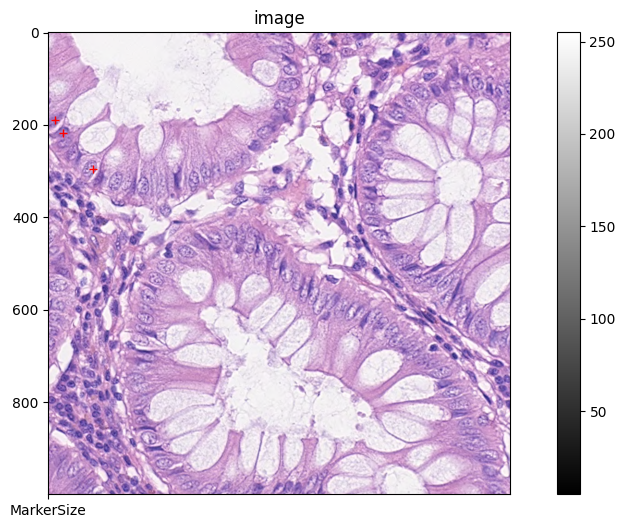

In [8]:
image_file = os.path.join(consep_dir, "Test", "Images", "test_12.png")
foreground = [[190, 15], [218, 32], [296, 96]]

reader = PILReader(converter=lambda im: im.convert("RGB"))
image_np = LoadImage(image_only=True, dtype=np.uint8, reader=reader)(image_file)

print(f"Image: {image_np.shape}\nForeground Points: {foreground}")
show_image(image_np, guidance=[foreground])

## Inference example using the transforms with a prediction from the network

--------------------------------------------------------------------------
Transform: LoadImaged
Image: torch.Size([1000, 1000, 3])
Foreground Points: [[190, 15], [218, 32], [296, 96]]


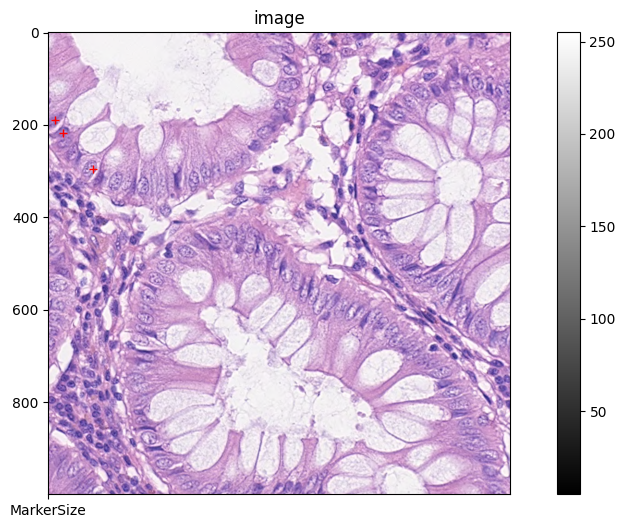

--------------------------------------------------------------------------
Transform: EnsureChannelFirstd
Image: torch.Size([3, 1000, 1000])
Foreground Points: [[190, 15], [218, 32], [296, 96]]


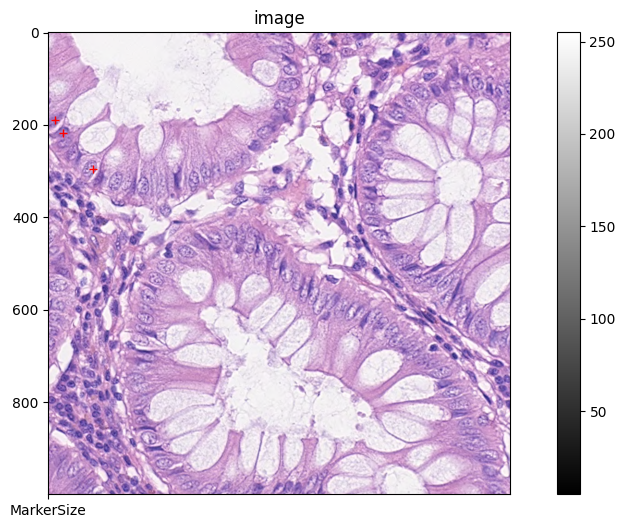

--------------------------------------------------------------------------
Transform: ScaleIntensityRanged
Image: torch.Size([3, 1000, 1000])
Foreground Points: [[190, 15], [218, 32], [296, 96]]
2022-12-06 10:38:12,826 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


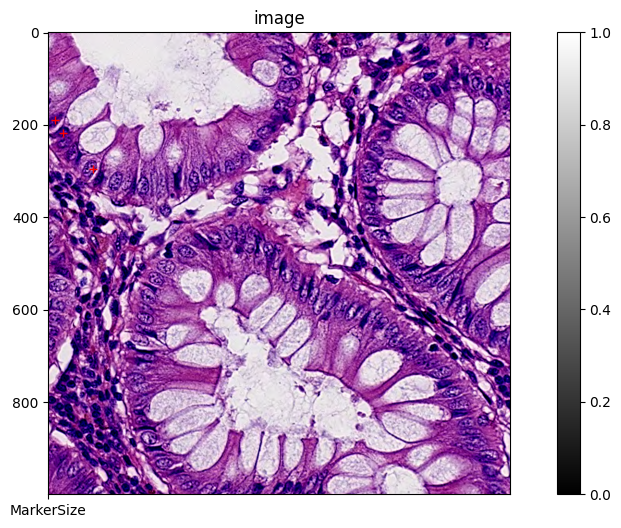

--------------------------------------------------------------------------
Transform: AddClickSignalsd
Image: torch.Size([3, 5, 128, 128])
Batch: 0 => Image: torch.Size([5, 128, 128]) => This Nuclei
2022-12-06 10:38:13,277 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


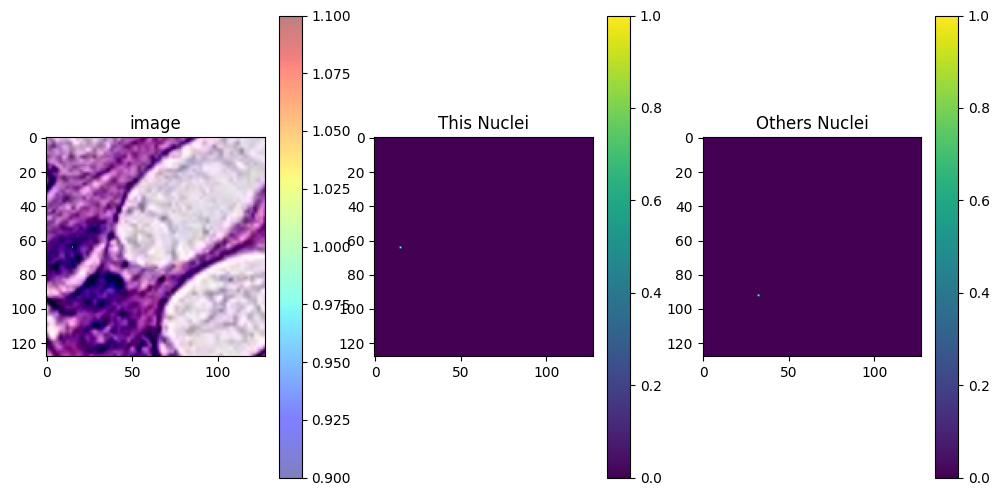

Batch: 1 => Image: torch.Size([5, 128, 128]) => This Nuclei
2022-12-06 10:38:13,870 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


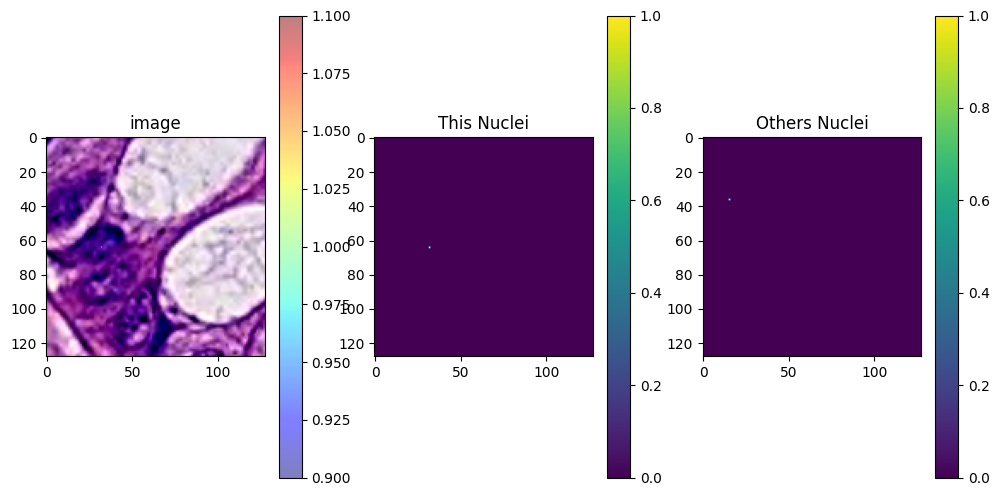

Batch: 2 => Image: torch.Size([5, 128, 128]) => This Nuclei
2022-12-06 10:38:14,753 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


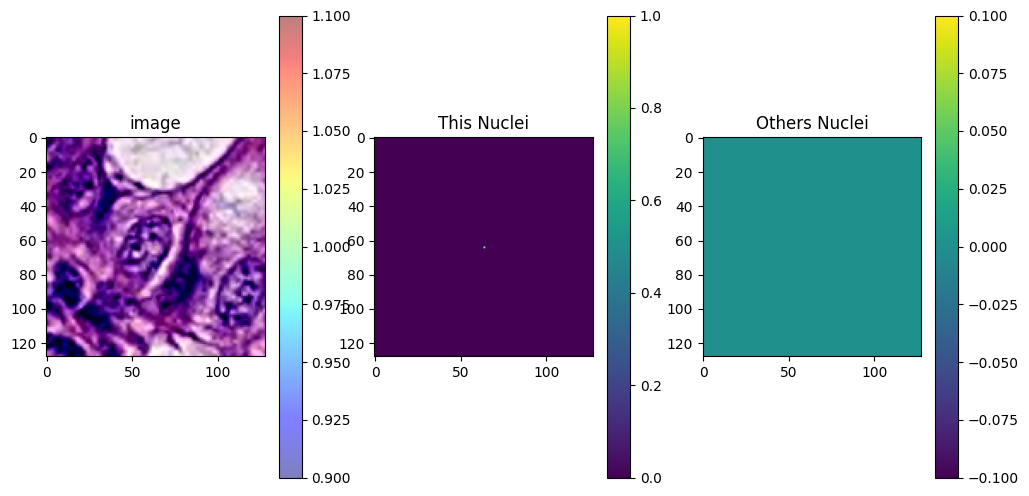

In [9]:
# Transforms
pre_transforms = [
    LoadImaged(keys="image", dtype=np.uint8, reader=PILReader(converter=lambda im: im.convert("RGB"))),
    EnsureChannelFirstd(keys="image"),
    ScaleIntensityRangeD(keys="image", a_min=0.0, a_max=255.0, b_min=-1.0, b_max=1.0),
    AddClickSignalsd(image="image", foreground="foreground", gaussian=False),
]

data = {"image": image_file, "foreground": foreground}

for t in pre_transforms:
    tname = type(t).__name__
    data = t(data)
    print("--------------------------------------------------------------------------")
    print(f"Transform: {tname}")
    if tname != "AddClickSignalsd":
        print(f"Image: {data['image'].shape}\nForeground Points: {data['foreground']}")
        show_image(convert_to_numpy(data["image"]), guidance=[foreground])
    else:
        print(f"Image: {data['image'].shape}")
        for bidx in range(data["image"].shape[0]):
            im = data["image"][bidx]
            print(f"Batch: {bidx} => Image: {im.shape} => This Nuclei")
            show_image(convert_to_numpy(im[:3]), convert_to_numpy(im[3]), sig=convert_to_numpy(im[4]))

Pred: torch.Size([3, 1, 128, 128])
Batch: 0 => Image: torch.Size([5, 128, 128]) => Pred: torch.Size([1, 128, 128])
2022-12-06 10:38:15,608 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


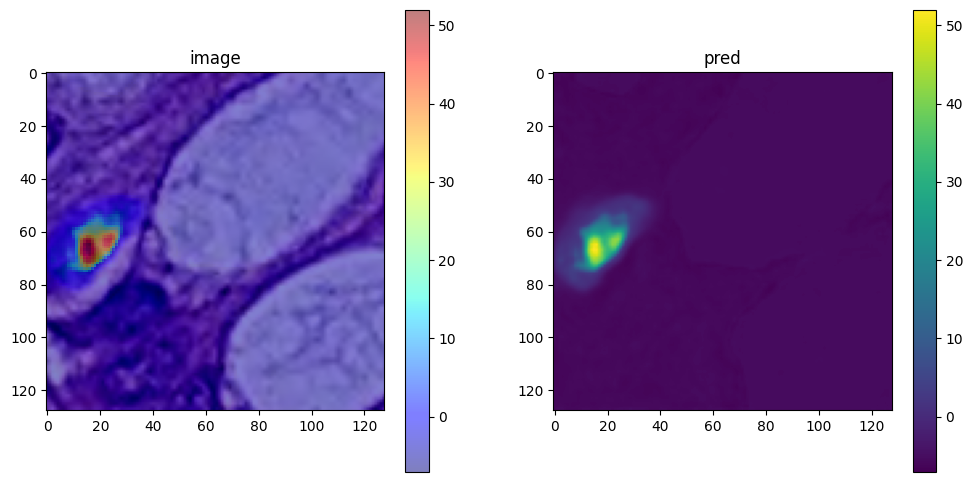

Batch: 1 => Image: torch.Size([5, 128, 128]) => Pred: torch.Size([1, 128, 128])
2022-12-06 10:38:16,096 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


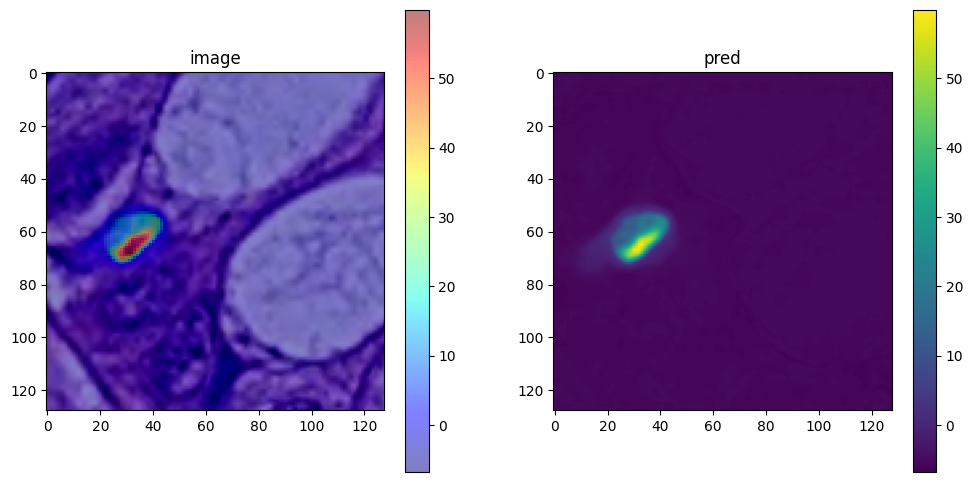

Batch: 2 => Image: torch.Size([5, 128, 128]) => Pred: torch.Size([1, 128, 128])
2022-12-06 10:38:16,621 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


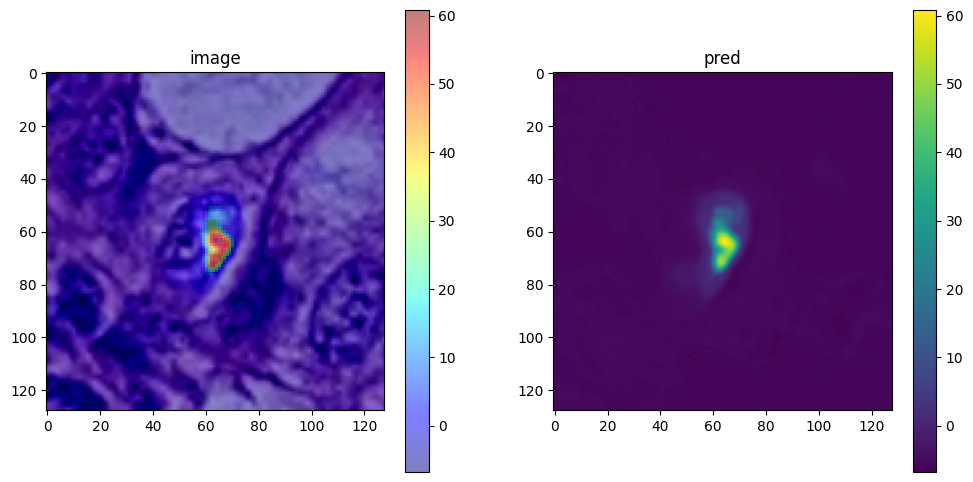

In [10]:
network.eval()
with torch.no_grad():
    pred = network(data["image"])

print(f"Pred: {pred.shape}")
for bidx in range(pred.shape[0]):
    im = data["image"][bidx]
    pr = pred[bidx]
    print(f"Batch: {bidx} => Image: {im.shape} => Pred: {pr.shape}")
    show_image(convert_to_numpy(im[:3]), convert_to_numpy(pr[0]))

--------------------------------------------------------------------------
Transform: Activationsd
Pred: torch.Size([3, 1, 128, 128]); dtype: torch.float32
Batch: 0 => Image: torch.Size([5, 128, 128]) => Pred: torch.Size([1, 128, 128])
2022-12-06 10:38:17,139 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


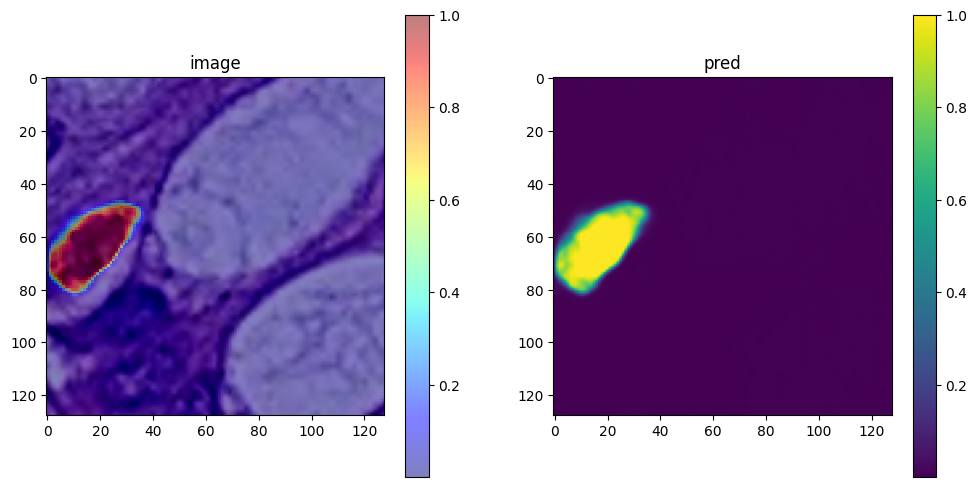

Batch: 1 => Image: torch.Size([5, 128, 128]) => Pred: torch.Size([1, 128, 128])
2022-12-06 10:38:17,668 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


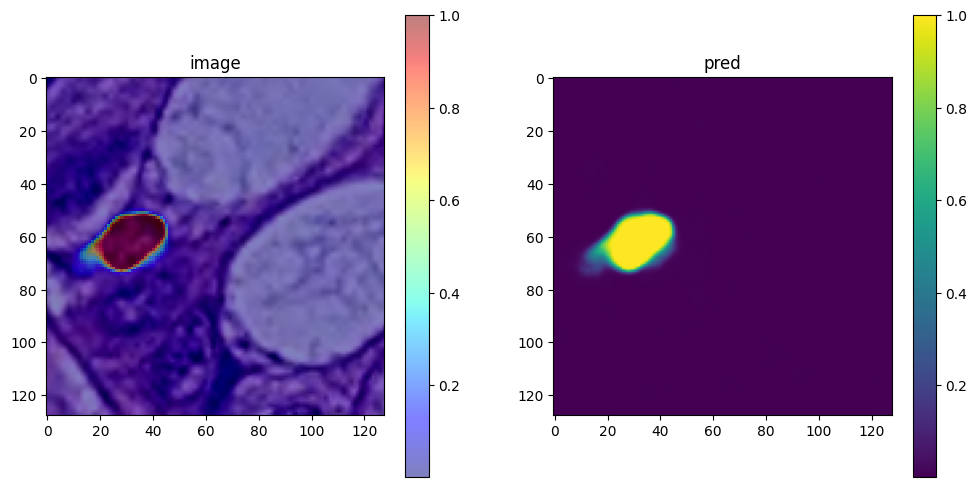

Batch: 2 => Image: torch.Size([5, 128, 128]) => Pred: torch.Size([1, 128, 128])
2022-12-06 10:38:18,197 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


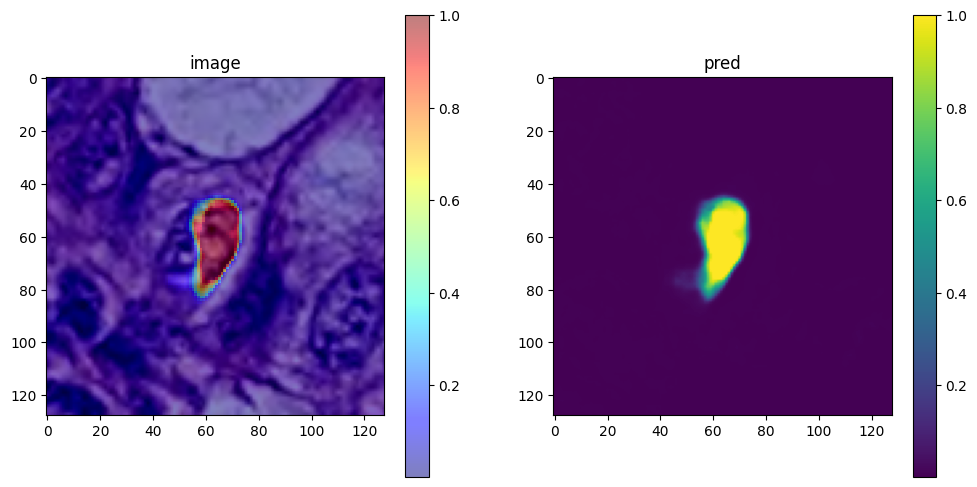

--------------------------------------------------------------------------
Transform: AsDiscreted
Pred: torch.Size([3, 1, 128, 128]); dtype: torch.uint8
Batch: 0 => Image: torch.Size([5, 128, 128]) => Pred: torch.Size([1, 128, 128])
2022-12-06 10:38:18,747 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


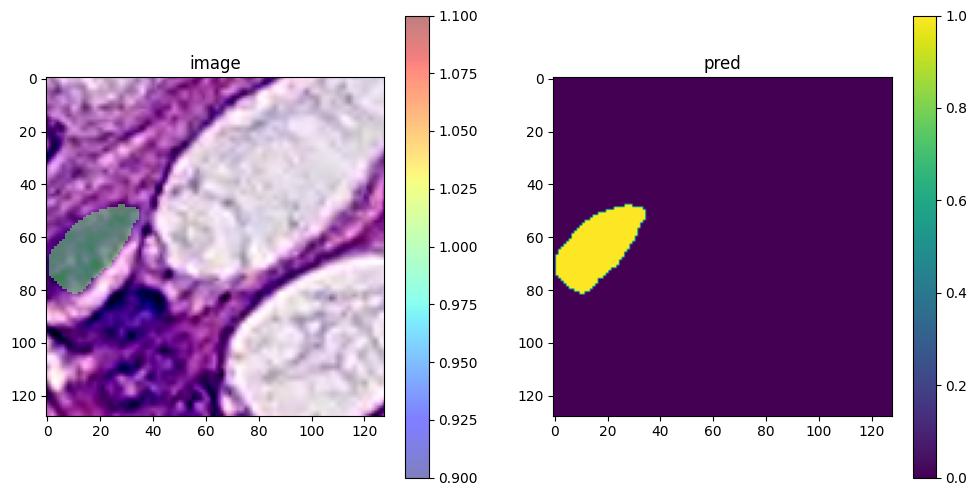

Batch: 1 => Image: torch.Size([5, 128, 128]) => Pred: torch.Size([1, 128, 128])
2022-12-06 10:38:19,493 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


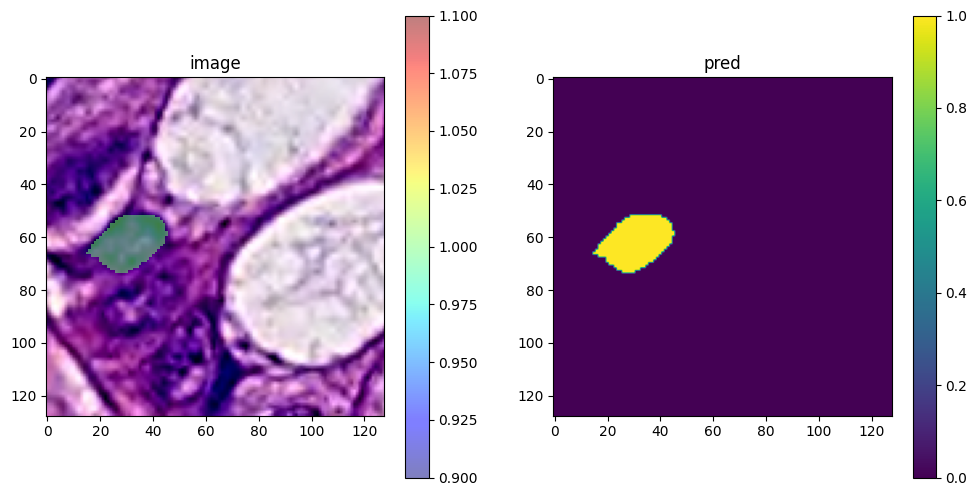

Batch: 2 => Image: torch.Size([5, 128, 128]) => Pred: torch.Size([1, 128, 128])
2022-12-06 10:38:20,034 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


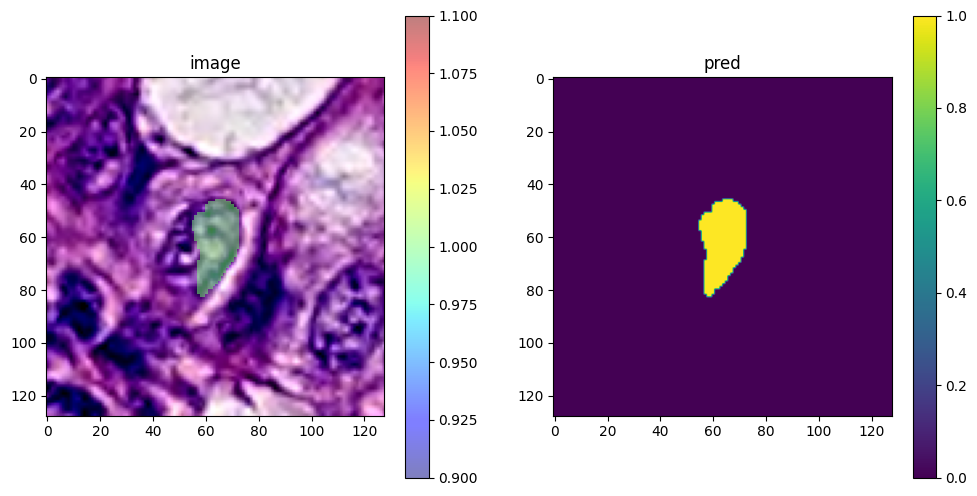

--------------------------------------------------------------------------
Transform: SqueezeDimd
Pred: torch.Size([3, 128, 128]); dtype: torch.uint8
Batch: 0 => Image: torch.Size([5, 128, 128]) => Pred: torch.Size([128, 128])
2022-12-06 10:38:20,541 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


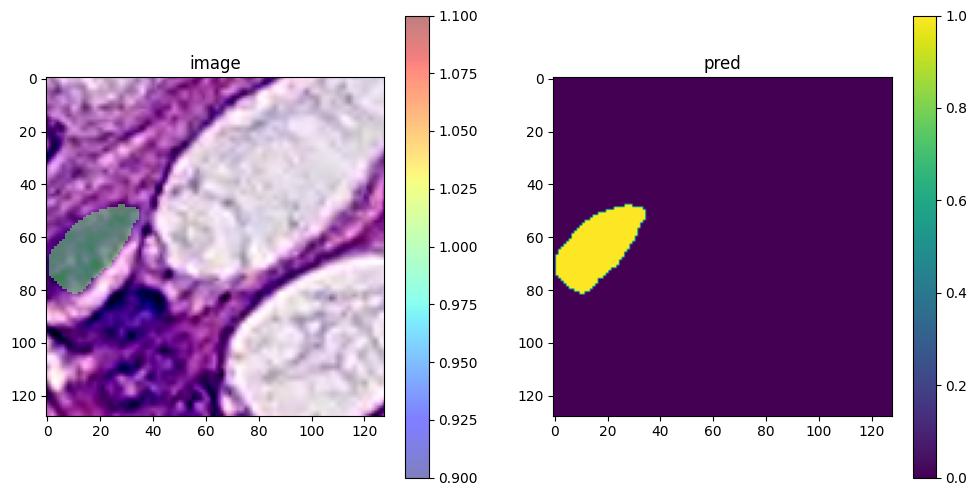

Batch: 1 => Image: torch.Size([5, 128, 128]) => Pred: torch.Size([128, 128])
2022-12-06 10:38:21,069 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


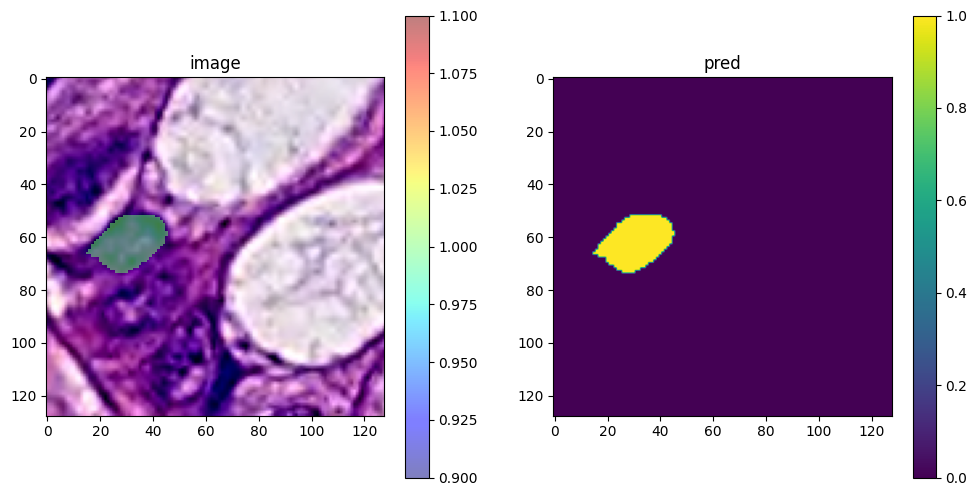

Batch: 2 => Image: torch.Size([5, 128, 128]) => Pred: torch.Size([128, 128])
2022-12-06 10:38:21,563 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


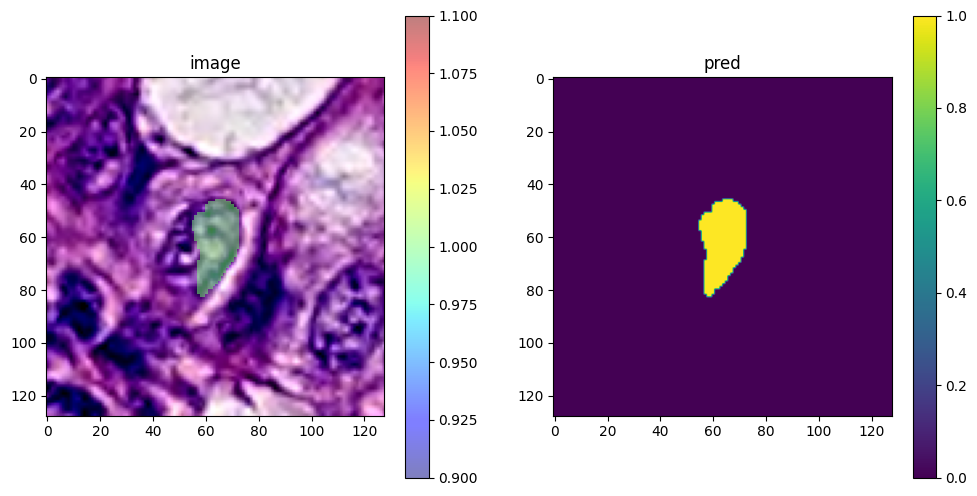

--------------------------------------------------------------------------
Transform: PostFilterLabeld
Pred: (1000, 1000); dtype: uint8


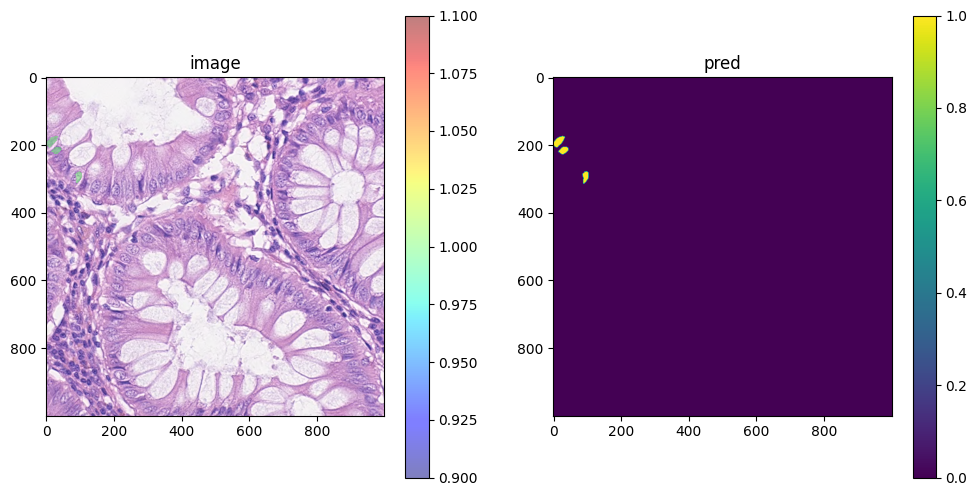

In [11]:
# Transforms
post_transforms = [
    Activationsd(keys="pred", sigmoid=True),
    AsDiscreted(keys="pred", threshold=0.5, dtype=np.uint8),
    SqueezeDimd(keys="pred", dim=1),
    PostFilterLabeld(keys="pred"),
]

data["pred"] = pred

for t in post_transforms:
    tname = type(t).__name__
    data = t(data)
    print("--------------------------------------------------------------------------")
    print(f"Transform: {tname}")
    print(f"Pred: {data['pred'].shape}; dtype: {data['pred'].dtype}")
    if tname == "PostFilterLabeld":
        show_image(convert_to_numpy(image_np), convert_to_numpy(data["pred"]))
        continue

    for bidx in range(data["pred"].shape[0]):
        im = data["image"][bidx]
        pr = data["pred"][bidx]
        print(f"Batch: {bidx} => Image: {im.shape} => Pred: {pr.shape}")
        show_image(convert_to_numpy(im[:3]), convert_to_numpy(pr[0] if pr.shape[0] == 1 else pr))

## End of Notebook